<a href="https://colab.research.google.com/github/Rijrya/ml-cell-classification/blob/main/cells.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q kaggle


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"minwoohwang","key":"2b6b662aaae11d957947c796f66b6fd4"}'}

In [ ]:
! mkdir ~/kaggle

! cp kaggle.json ~/kaggle/

In [ ]:
!chmod 600 ~/kaggle/kaggle.json

In [ ]:
!mv /root/kaggle/kaggle.json /root/.kaggle/kaggle.json


In [ ]:
!kaggle datasets list

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 403, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [ ]:
!kaggle datasets download -d masoudnickparvar/white-blood-cells-dataset

 99% 496M/499M [00:19<00:00, 35.3MB/s]
100% 499M/499M [00:19<00:00, 27.4MB/s]


In [ ]:
import zipfile

zip_ref = zipfile.ZipFile("white-blood-cells-dataset.zip")
zip_ref.extractall()
zip_ref.close()

In [ ]:
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "Train"
test_dir = "Test-A"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)
augment_datagen = keras.Sequential([preprocessing.RandomRotation(1.0),
                                   preprocessing.RandomFlip("horizontal")])

print("Training images:")
train_data_a = train_datagen.flow_from_directory(train_dir,
                                                         target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")

print("Testing images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")

Training images:
Found 10175 images belonging to 5 classes.
Testing images:
Found 4339 images belonging to 5 classes.


using efficientnetb0 i think

In [ ]:
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
import datetime

# Create ModelCheckpoint callback to save model's progress
checkpoint_path = "model_checkpoints/cp.ckpt" # saving weights requires ".ckpt" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=True, # only save model weights (not whole model)
                                                      )

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

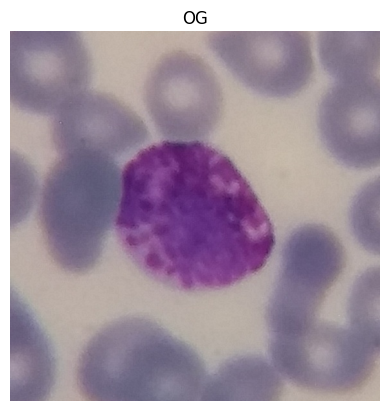

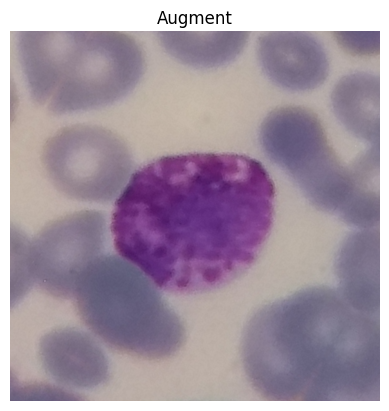

In [ ]:
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

augmented_images = []

target_class = "Basophil"
target_dir = "Train/" + target_class

random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title("OG")
plt.axis(False);

augmented_images = augment_datagen(tf.expand_dims(img, axis=0), training=True)
plt.figure()
plt.axis(False)
plt.imshow(tf.squeeze(augmented_images)/255.)
plt.title("Augment");


In [ ]:
from PIL import Image

def save_image(image, file_path):
    # Convert the image from a NumPy array to a PIL Image
    img = Image.fromarray(image)

    # Save the image to the specified file path
    img.save(file_path)

def balance_dataset(input_dir):

    # Get a list of subdirectories (each representing a class)
    class_dirs = [os.path.join(input_dir, subdir) for subdir in os.listdir(input_dir) if os.path.isdir(os.path.join(input_dir, subdir))]

    # Find the maximum number of images in a class: 6231
    # max_images = max([len(os.listdir(class_dir)) for class_dir in class_dirs])

    for class_dir in class_dirs:
        class_name = os.path.basename(class_dir)

        # Load images from the class directory
        image_files = [os.path.join(class_dir, filename) for filename in os.listdir(class_dir)]

        # Calculate the number of augmentations needed to match the max_images
        num_augmentations = 6231 - len(image_files)

        if num_augmentations > 0:
            # Perform data augmentation to balance the class
            for i in range(num_augmentations):
              random_image = random.choice(os.listdir(input_dir))
              random_image_path = input_dir + "/" + random_image

              img = mpimg.imread(random_image_path)
              augmented_images = augment_datagen(tf.expand_dims(img, axis=0), training=True)
              augmented_image = next(augmented_images)[0]
              save_image(augmented_image, os.path.join(input_dir, f"augmented_{len(image_files) + i}.jpg"))



    class_counts = {class_name: len(os.listdir(class_dir)) for class_name, class_dir in zip([os.path.basename(class_dir) for class_dir in class_dirs], class_dirs)}
    print("Final class distribution after balancing:")
    print(class_counts)

input_dir = "Train/Basophil"
balance_dataset(input_dir)



Final class distribution after balancing:
{}


In [ ]:
def create_model(model_url, num_classes=10):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output nerons in the output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor
    layer and Dense output layer with num_classes output neurons.
  """

  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the already learned patterns
                                           name="feature_extraction_layer",
                                           input_shape=IMAGE_SHAPE+(3,))

  # Create our own model
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])

  return model

In [ ]:
efficientnet_model = create_model(model_url=efficientnet_url,
                                  num_classes=train_data_a.num_classes)

efficientnet_model.compile(loss="categorical_crossentropy",
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=["accuracy"])

efficientnet_history = efficientnet_model.fit(train_data_a,
                                              epochs=5,
                                              steps_per_epoch=len(train_data_a),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="trained_model",
                                                                                experiment_name="cells"),
                                                    model_checkpoint]
                                              )

Saving TensorBoard log files to: trained_model/cells/20230912-035548
Epoch 1/5
318/318 [==============================] - 57s 146ms/step - loss: 0.5082 - accuracy: 0.8196 - val_loss: 0.3195 - val_accuracy: 0.9011
Epoch 2/5
318/318 [==============================] - 45s 141ms/step - loss: 0.2757 - accuracy: 0.9118 - val_loss: 0.2558 - val_accuracy: 0.9189
Epoch 3/5
318/318 [==============================] - 44s 138ms/step - loss: 0.2188 - accuracy: 0.9322 - val_loss: 0.2253 - val_accuracy: 0.9276
Epoch 4/5
318/318 [==============================] - 45s 140ms/step - loss: 0.1885 - accuracy: 0.9419 - val_loss: 0.1994 - val_accuracy: 0.9325
Epoch 5/5
318/318 [==============================] - 46s 145ms/step - loss: 0.1692 - accuracy: 0.9463 - val_loss: 0.2025 - val_accuracy: 0.9311


In [ ]:
import matplotlib.pyplot as plt

# Plot the validation and training curves
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics

  Args:
    history: TensorFlow History object.

  Returns:
    Plots of training/validation loss and accuracy metrics.
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # Plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()


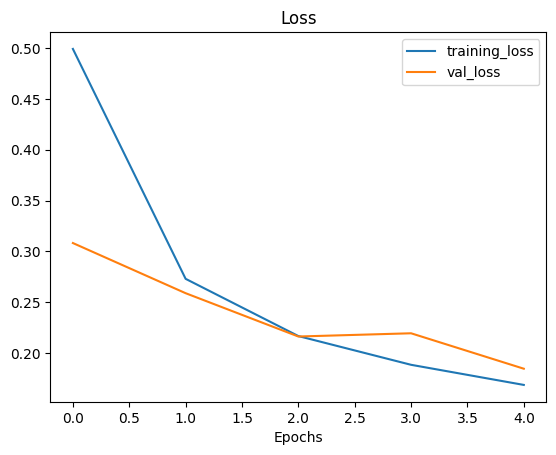

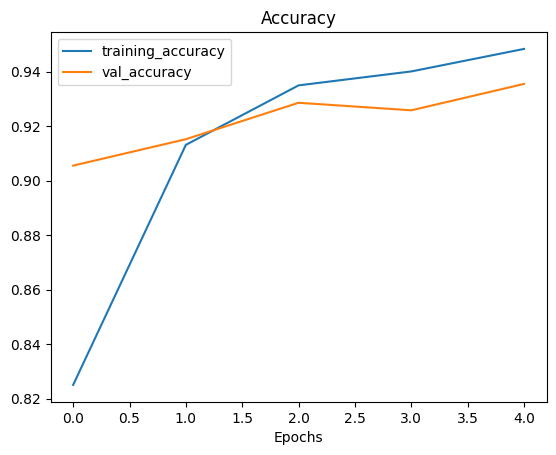

In [ ]:
plot_loss_curves(efficientnet_history)

In [ ]:
efficientnet_model.load_weights(checkpoint_path)

In [ ]:
loaded_weights_model_results = efficientnet_model.evaluate(test_data)

136/136 [==============================] - 13s 96ms/step - loss: 0.1994 - accuracy: 0.9325
